In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [6]:
error_node_length = list(map(lambda x: int(x.strip()),open('step_length_analysss.txt','r').readlines()))

(0.0, 60.0)

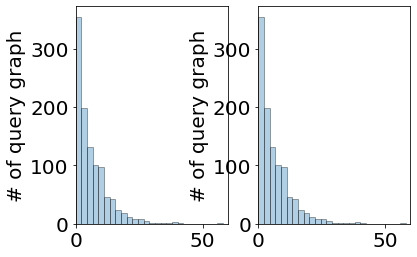

In [26]:
ax1 = plt.subplot(1, 2, 1)
plt.hist(error_node_length,bins=30,edgecolor='k', alpha=0.35)
plt.xlim(0,60)
plt.ylabel('# of query graph')
plt.xlabel('error node position')
ax2 = plt.subplot(1, 2, 2, sharey=ax1) # 与 ax1 共享y轴
plt.hist(error_node_length,bins=30,edgecolor='k', alpha=0.35)
plt.ylabel('# of query graph')
plt.xlabel('# of node')
plt.xlim(0,60)


## Futher Analysis

In [3]:
import os
import torch
import argparse
from util import setup_seed
import logging
import coloredlogs
from transformers import BertTokenizer
from user_dataset import Task1Dataset,GraphDataLoader,TrmDataloader,TrmDataloader_task2,Task2Dataset
from model import GraphNet,TreeLstmNet,TransformerNet,TransformerNet_task2
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tqdm import tqdm

Using backend: pytorch


## 分支数据与不分枝数据

In [ ]:
no_branch = 90
branch = 17

## 统计每个数据的长度

In [3]:
task1_file = '/remote-home/my/operation_detection/new_data/dataset_list/dgl_old_test_list.pkl'
task2_file = '/remote-home/my/operation_detection/new_data/dataset_list/task2_dgl_old_test_list.pkl'
task1_list = torch.load(task1_file)
task2_list = torch.load(task2_file)

In [3]:
length = []
for data in task1_list:
    length.append(len(data[1].nodes()))

## Task2

In [4]:
BERT_PATH = '/remote-home/my/operation_detection/bert-base-chinese'
VOCAB = 'vocab.txt'
tokenizer = BertTokenizer.from_pretrained(os.path.join(BERT_PATH, VOCAB))
dataset = Task2Dataset("/remote-home/my/operation_detection/new_data/origin_data/old_decision_created_data.json",
                        "/remote-home/my/operation_detection/new_data/origin_data/old_sequence_created_data.json",
                        tokenizer=tokenizer,
                        test=True,
                        procedure_triple_path = '/remote-home/my/operation_detection/new_data/procedure_graph/procedure_graph.csv')
BERT_PATH = '/remote-home/my/operation_detection/bert-base-chinese'
model = TransformerNet_task2(BERT_PATH,compute_relative = 1,add_external = 1,add_context = 1, add_main_feature= 1,num_layers=3)
model.load_state_dict(torch.load('/remote-home/my/operation_detection/best_model/'+'task%s-%s-%s-%s-%s_'%\
                            (str(2),'TransformerNet',str(1),str(1),str(1))+\
                                'best_parameter.pkl'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [5]:
id = 99
instance = dataset[id]

In [6]:
text = instance[0]
query_graph = instance[1].ndata['x']
KG = instance[2]
answer = instance[4]
answer_label = instance[5]

def convert_bert_ids(text):
    fulltext = ''.join(tokenizer.convert_ids_to_tokens(text.numpy())).replace('[SEP]','').replace('#','').replace('[CLS]','')
    return fulltext
fulltext = convert_bert_ids(text[0,0:int(text.shape[1]/3)])
full_node = []
for i in range(query_graph.shape[0]):
    node = query_graph[i]
    full_node.append(convert_bert_ids(node[0:int(node.shape[0]/3)]).replace('[PAD]',''))
answer_candidates = []
for i in range(answer.shape[0]):
    node = answer[i]
    answer_candidates.append(convert_bert_ids(node[0:int(node.shape[0]/3)]).replace('[PAD]',''))
true_answer = answer_candidates[answer_label]
KG.x
KG_node = []
for i in range(KG.x.shape[0]):
    node = KG.x[i]
    KG_node.append(convert_bert_ids(node[0:int(node.shape[0]/3)]).replace('[PAD]',''))

In [7]:
print(answer_candidates, answer_label)
# KG_node

['走线爪对齐[UNK]site[UNK]', '走线爪对齐bbu盒体上孔位', '走线爪微调bbu盒体上孔位'] 1


In [8]:
loader = TrmDataloader_task2
testloader = loader([instance], batch_size=1,num_workers=16,pin_memory=True)
with torch.no_grad():
    model.eval()
    task2_predict = []
    task2_label = []
    for batch in tqdm(testloader,ncols = 80):
        if len(batch)==6:
            data,text,subgraph,topological_list,answer_choice,y = batch
        else:
            data,text,subgraph,answer_choice,y = batch
        if isinstance(data, list):
            data,text,subgraph,answer_choice,y = list(map(lambda x:x.to(device),data)),text.to(device),subgraph.to(device),answer_choice.to(device),y.to(device)
            output,attention_c= model(data,text,subgraph,topological_list,answer_choice)
        else:
            data,text,subgraph,answer_choice,y = data.to(device),text.to(device),subgraph.to(device),answer_choice.to(device),y.to(device)
            output = model(data,text,subgraph,answer_choice)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


In [9]:
len(full_node),len(KG_node)

(10, 17)

In [10]:
minv,maxv = torch.min(attention_c).item(),torch.max(attention_c).item()

In [11]:
print(output)
print(y)


tensor([[26.3547, 22.0936, 19.6128]], device='cuda:0')
tensor([1], device='cuda:0')


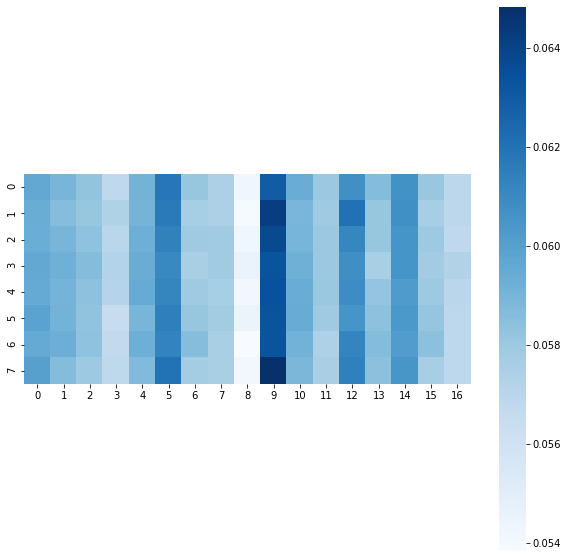

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
Attention_c = pd.DataFrame(attention_c[0][0:9,:].detach().cpu().numpy())
plt.subplots(figsize=(10, 10))  # 设置画面大小
sns.heatmap(Attention_c, annot=False, vmax = maxv,vmin = minv, square=True, cmap="Blues")
plt.savefig('./BluesStateRelation.png')
plt.show()

In [25]:
KG_node[5]

'紧固'

In [28]:
KG_node

['走线爪',
 '接地螺钉',
 'bbu挂耳',
 '安装',
 '机柜',
 '紧固',
 'm6x16紧固螺钉',
 '推入到',
 '置为',
 'bbu盒体上孔位',
 '螺钉',
 'bbu',
 'spdalm监控信号线',
 '拧紧',
 '拆卸',
 'm6x12紧固螺钉',
 'bbu走线爪']

In [26]:
full_node

['操作者拆卸bbu挂耳',
 '操作者拆卸接地螺钉',
 '操作者拧紧m6x12紧固螺钉',
 '操作者安装bbu走线爪',
 '[MASK][MASK][MASK]',
 '操作者紧固螺钉',
 'bbu推入到机柜',
 '操作者拧紧m6x16紧固螺钉',
 '',
 '']

In [21]:
instance[1].edges()

(tensor([8, 0, 1, 2, 3, 4, 5, 2, 6, 7]),
 tensor([0, 1, 2, 3, 4, 5, 6, 6, 7, 9]))

In [173]:
fulltext.replace('[PAD]','')

'dbs3900安装omb（ver.c）拆卸bbu挂耳，如下图所示。拆卸2颗接地螺钉，如下图所示。将挂耳调整为正装，拧紧4颗m6x12紧固螺钉，紧固力矩为2n·m，如下图所示。可选：当bbu安装在apm30h/tmc11h中时，需要安装bbu走线爪。将走线爪与bbu盒体上孔位对齐，用2颗m4螺钉紧固，紧固力矩为1.2n·m，如下图所示。将bbu沿着滑道推入到机柜中，拧紧4颗m6x16紧固螺钉，紧固力矩为2n·m，如下图所示。'

In [126]:
KG_node.index('m4螺钉')

ValueError: 'm4螺钉' is not in list

In [11]:
loader = TrmDataloader_task2
testloader = loader(task2_list, batch_size=1,num_workers=16,pin_memory=True)
BERT_PATH = '/remote-home/my/operation_detection/bert-base-chinese'
model = TransformerNet_task2(BERT_PATH,compute_relative = 1,add_external = 1,add_context = 1, add_main_feature= 1,num_layers=3)
model.load_state_dict(torch.load('/remote-home/my/operation_detection/best_model/'+'task%s-%s-%s-%s-%s_'%\
                            (str(2),'TransformerNet',str(1),str(1),str(1))+\
                                'best_parameter.pkl'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
with torch.no_grad():
    model.eval()
    task2_predict = []
    task2_label = []
    for batch in tqdm(testloader,ncols = 80):
        if len(batch)==6:
            data,text,subgraph,topological_list,answer_choice,y = batch
        else:
            data,text,subgraph,answer_choice,y = batch
        if isinstance(data, list):
            data,text,subgraph,answer_choice,y = list(map(lambda x:x.to(device),data)),text.to(device),subgraph.to(device),answer_choice.to(device),y.to(device)
            output= model(data,text,subgraph,topological_list,answer_choice)
        else:
            data,text,subgraph,answer_choice,y = data.to(device),text.to(device),subgraph.to(device),answer_choice.to(device),y.to(device)
            output,attention_m = model(data,text,subgraph,answer_choice)


100%|█████████████████████████████████████████| 107/107 [01:35<00:00,  1.12it/s]


In [13]:
f1_score(task2_label, task2_predict, average='macro')

0.7578565672844481

In [23]:
branch_f1 = f1_score(task2_label[90:], task2_predict[90:], average='macro')
branch_acc = accuracy_score(task2_label[90:], task2_predict[90:])
branch_recall = recall_score(task2_label[90:], task2_predict[90:], average='macro')
branch_pre = precision_score(task2_label[90:], task2_predict[90:], average='macro')
print(branch_acc,branch_f1,branch_pre,branch_recall)

branch_f1 = f1_score(task2_label[:90], task2_predict[:90], average='macro')
branch_acc = accuracy_score(task2_label[:90], task2_predict[:90])
branch_recall = recall_score(task2_label[:90], task2_predict[:90], average='macro')
branch_pre = precision_score(task2_label[:90], task2_predict[:90], average='macro')
print(branch_acc,branch_f1,branch_pre,branch_recall)

0.7058823529411765 0.6988344988344988 0.7000000000000001 0.7047619047619048
0.7666666666666667 0.7679467485919099 0.7705097570688969 0.7826676907322069


In [25]:
length_zip = list(zip(length,task2_label,task2_predict))
length_zip = sorted(length_zip,key = lambda x:x[0])

(array([19., 38., 11., 11.,  8.,  8.,  5.,  3.,  1.,  3.]),
 array([ 4. ,  8.1, 12.2, 16.3, 20.4, 24.5, 28.6, 32.7, 36.8, 40.9, 45. ]),
 <BarContainer object of 10 artists>)

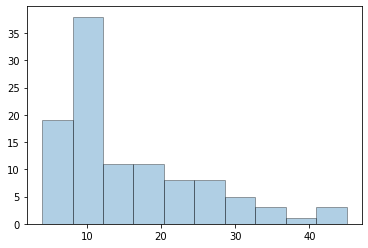

In [32]:
plt.hist(length,bins=10,edgecolor='k', alpha=0.35)

In [83]:
list(zip(*group1))

[(4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8),
 (1, 0, 0, 2, 2, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2, 0),
 (1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0)]

In [118]:
group1 = length_zip[:10]#<=6 10
group2 = length_zip[11:27]#6<=9 15
group3 = length_zip[28:46]# 9< <=11 16
group4 = length_zip[47:62]# 11< <=13 15
group5 = length_zip[63:79]# 12< <=19 16
group6 = length_zip[80:]# 19< <=28 17


In [122]:
group5

[(14, 2, 2),
 (14, 2, 2),
 (15, 2, 0),
 (15, 0, 0),
 (15, 2, 2),
 (17, 1, 1),
 (18, 0, 0),
 (18, 2, 2),
 (18, 1, 1),
 (18, 2, 0),
 (18, 0, 0),
 (19, 1, 1),
 (19, 0, 0),
 (19, 1, 1),
 (19, 0, 0),
 (19, 1, 1)]

In [123]:
l = [group1,group2,group3,group4,group5,group6]
for group in l:
    _,label,predict = list(zip(*group))
    f1 = f1_score(label, predict, average='macro')
    acc = accuracy_score(label, predict)
    recall = recall_score(label, predict, average='macro')
    pre = precision_score(label, predict, average='macro')
    print(acc,pre,recall,f1)


0.8 0.8333333333333334 0.8055555555555555 0.8023809523809523
0.5625 0.5777777777777778 0.6518518518518519 0.5380952380952382
0.8333333333333334 0.8301587301587302 0.85 0.8363636363636364
0.7333333333333333 0.707936507936508 0.7833333333333333 0.7333333333333333
0.875 0.9047619047619048 0.8888888888888888 0.8777777777777778
0.7037037037037037 0.6786916786916786 0.7008547008547009 0.6777777777777777


## Task1 

In [124]:
loader = TrmDataloader
testloader = loader(task1_list, batch_size=1,num_workers=16,pin_memory=True)
BERT_PATH = '/remote-home/my/operation_detection/bert-base-chinese'
model = TransformerNet(BERT_PATH,compute_relative = 1,add_external = 0,add_context = 0, add_main_feature= 1,num_layers=3)
model.load_state_dict(torch.load('/remote-home/my/operation_detection/best_model/task1-TransformerNet-0-0-1_best_parameter.pkl'))
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.to(device)
with torch.no_grad():
    model.eval()
    task2_predict = []
    task2_label = []
    for batch in tqdm(testloader,ncols = 80):
        if len(batch)==4:
            data,text,subgraph,topological_list = batch
        else:
            data,text,subgraph = batch
        if isinstance(data, list):
            data,text,subgraph = list(map(lambda x:x.to(device),data)),text.to(device),subgraph.to(device)
            output,y = model(data,text,subgraph,topological_list)
        else:
            data,text,subgraph = data.to(device),text.to(device),subgraph.to(device)
            y = data.ndata['y']
            output = model(data,text,subgraph)
        task1_label.append(y.detach().cpu().numpy().tolist())
        task1_predict.append(torch.max(output,dim=1)[1].detach().cpu().numpy().tolist())

RuntimeError: [enforce fail at inline_container.cc:222] . file not found: archive/data/94019535311680